<a href="https://colab.research.google.com/github/proteus21/COMPUTER-VISION/blob/main/3_Dog_Breed_Identification/Dog__Breed__Identification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DOG BREED IDENTIFICATION

###Source Datasets

https://www.kaggle.com/competitions/dog-breed-identification/data

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

Train dir contains 10K dogs inages
Image name is id of image
labels.csv contains id vs breed mapping

### <a name='0'></a> Installation of the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# mounting google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <a name='1'></a> Downloading datasets from Kaggle to google drive

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"


In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:

import os

os.environ['KAGGLE_USERNAME'] = "xxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxxx" # key from the json file

!kaggle competitions download -c dog-breed-identification

100% 689M/691M [00:31<00:00, 25.0MB/s]
100% 691M/691M [00:31<00:00, 23.3MB/s]


In [ ]:
 !unzip -uq "/content/drive/MyDrive/Kaggle/dog-breed-identification.zip" -d "/content/drive/MyDrive/Kaggle/" # unzip file in google drive

### <a name='2'></a> Import  of libraries

In [ ]:
!pip install opencv-python==4.6.0.66

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


Save all requirements libraries in content

In [ ]:
#!pip freeze > requirements.txt

Install all required libraries from content folder in Colab after paste requirmetnts.txt file

In [ ]:
!pip install -r '/content/requirements.txt' # It works when you have clear colab

### <a name='3'></a>  Load libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import cv2
import imutils
from glob import glob # listnening names as pattern
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import plotly.express as px

print(f"Tensorflow {tf.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Numpy {np.__version__}")
print(f"OpenCV-{cv2.__version__}")


print(os.path.abspath('.'))


Tensorflow 2.12.0
Pandas 1.5.3
Numpy 1.22.4
OpenCV-4.7.0
/content


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### <a name='4'></a>  Understanding data sets and problems

###Image  - pre-analyse

In [3]:
IMAGE_SIZE=224

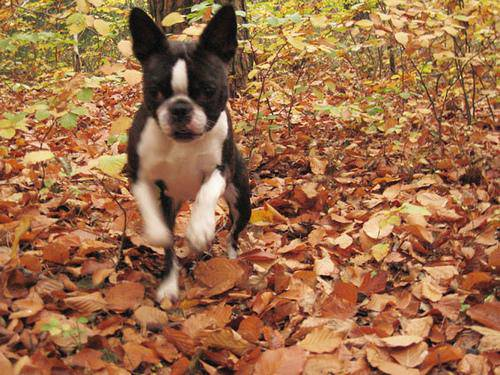

In [4]:
path = "/content/drive/MyDrive/Kaggle/train/000bec180eb18c7604dcecc8fe0dba07.jpg"
image = cv2.imread(path,1)
cv2_imshow(image)

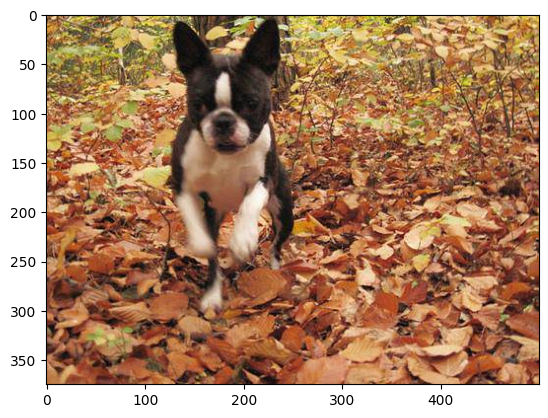

In [5]:
filename = "/content/drive/MyDrive/Kaggle/train/000bec180eb18c7604dcecc8fe0dba07.jpg"
car_img = cv2.imread(filename,1)
car_img=cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
plt.imshow(car_img)

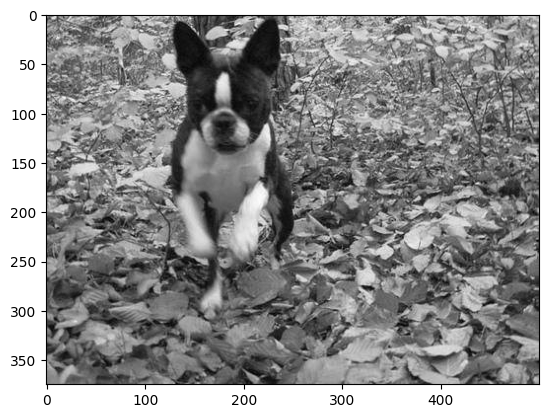

In [6]:
gray = cv2.cvtColor(car_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

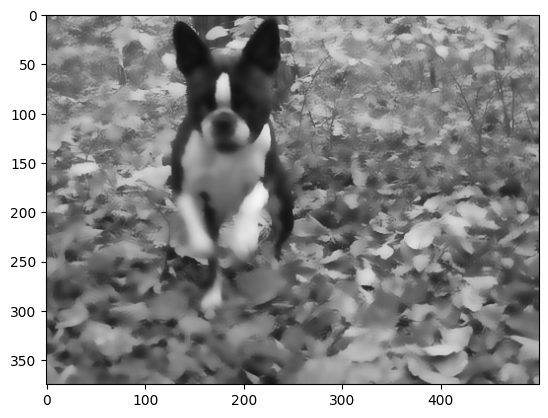

In [7]:
blurred_gray = cv2.bilateralFilter(gray, 10, 50, 50)
plt.imshow(blurred_gray, cmap='gray', vmin=0, vmax=255)

(375, 500)


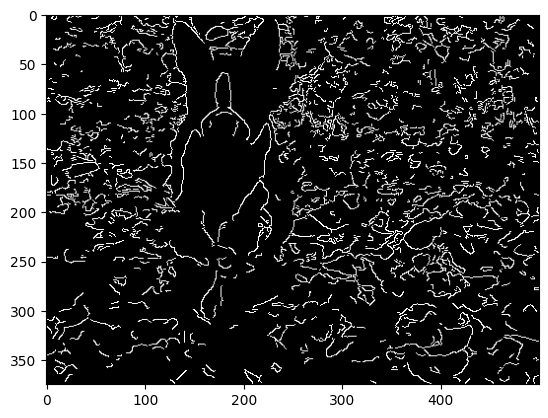

In [8]:
edged = cv2.Canny(blurred_gray, 140, 200)
print(edged.shape)
plt.imshow(edged, cmap='gray', vmin=0, vmax=255)

Target information from labels.csv

In [9]:

print((os.path.join(('.'),'labels.csv')))

./labels.csv


In [10]:
#labels=pd.read_csv(((os.path.join(('.'),'labels.csv'))))
labels=pd.read_csv('/content/drive/MyDrive/Kaggle/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
print((os.path.join(('.'),'train')))

./train


In [12]:
#files=os.listdir(os.path.join(('.'),'train'))
#files[:5]
files=sorted(os.listdir("/content/drive/MyDrive/Kaggle/train"), reverse=False)
files[:5]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg']

In [13]:
df_files=pd.DataFrame({'id':list(map(lambda x:x.replace('.jpg',''), files))})
df_files.head()

,id
0,000bec180eb18c7604dcecc8fe0dba07
1,001cdf01b096e06d78e9e5112d419397
2,00214f311d5d2247d5dfe4fe24b2303d
3,0021f9ceb3235effd7fcde7f7538ed62
4,00290d3e1fdd27226ba27a8ce248ce85


###Mapping file with breed


In [14]:
label_info=pd.merge(left=df_files, right=labels)
label_info

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001cdf01b096e06d78e9e5112d419397,pekinese
2,00214f311d5d2247d5dfe4fe24b2303d,bluetick
3,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
4,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
...,...,...
4198,9fe57edea044ecd8bfa235f3644cf05c,french_bulldog
4199,9fe7b8f0306f2baf466abb878d11576c,redbone
4200,9fe860ddf6ea9ca602dc6da23fb10b74,english_springer
4201,9ff162b5cdfe5b67a6d7bb684d36795e,miniature_pinscher


In [15]:
#IMAGE_SIZE=224
image_dir="/content/drive/MyDrive/Kaggle/train"
path=os.path.join(image_dir, '*g')
#files=glob(path)
files=sorted(glob(path),reverse = False)

X=[]
k=0
for f in files:
  img=cv2.imread(f)
  img=cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))
  # Limiting photos for Colab - normal version
  if k <4203:
    X.append(np.array(img))
    k+=1



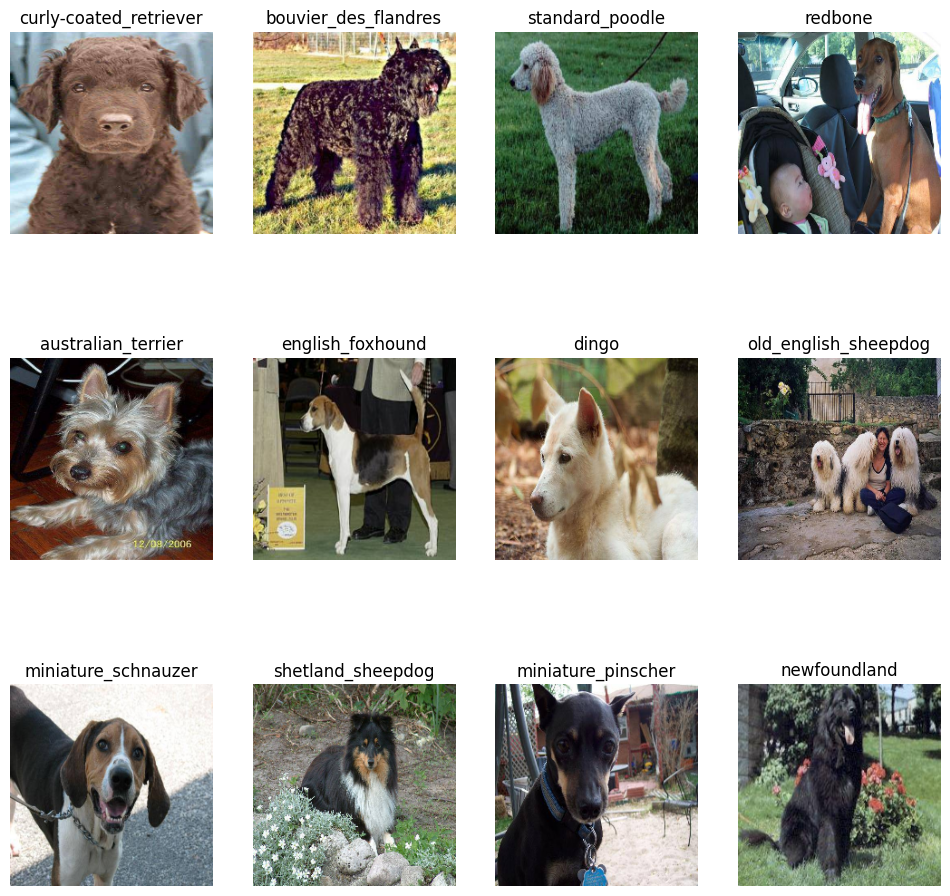

In [16]:
dataset_index=[]
for i in range (12):
  dataset_index.append(np.random.randint(0, len(X)))

plt.figure(figsize=(12, 12))
for index, i  in enumerate(dataset_index):
  plt.subplot(3,4,index+1)
  plt.axis('off')
  plt.title(label_info.iloc[i]['breed'])
  plt.imshow(cv2.cvtColor(X[i],cv2.COLOR_BGR2RGB))

In [17]:
label_info.iloc[648]['breed']

'great_pyrenees'

Converting target to One-Hot-Vector format

In [18]:
num_classes=len(label_info.breed.unique())
num_classes

120

In [19]:
label_info.breed

0                 boston_bull
1                    pekinese
2                    bluetick
3            golden_retriever
4          bedlington_terrier
                ...          
4198           french_bulldog
4199                  redbone
4200         english_springer
4201       miniature_pinscher
4202    flat-coated_retriever
Name: breed, Length: 4203, dtype: object

In [20]:
label_info.describe()

,id,breed
count,4203,4203
unique,4203,120
top,000bec180eb18c7604dcecc8fe0dba07,australian_terrier
freq,1,53


In [21]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
labelE=LabelEncoder()
breed=labelE.fit_transform(label_info.breed)
y=np_utils.to_categorical(breed,num_classes=num_classes)

Convert images to numpy array

In [22]:
X=np.array(X)
y=np.array(y)

In [23]:
print(X.shape)
print(y.shape)

(4203, 224, 224, 3)
(4203, 120)


In [24]:
from tensorflow.python import train
X_train,X_test,y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=42)


###Create callbacks

In [25]:
from keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19

vgg_model=VGG19(weights='imagenet', include_top=False)

x=vgg_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
out=Dense(120,activation='Softmax')(x)

model=Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers:
  layer.trainable=False

from keras.optimizers import Adam

optim=Adam()

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
history=model.fit(X_train,y_train, batch_size=256, epochs=40, validation_data=(X_val, y_val), callbacks=[earlystop])
model.save('model.h5')

Epoch 1/40
12/12 [==============================] - 80s 4s/step - loss: 20.5766 - accuracy: 0.0119 - val_loss: 14.4564 - val_accuracy: 0.0148
Epoch 2/40
12/12 [==============================] - 16s 1s/step - loss: 15.5192 - accuracy: 0.0231 - val_loss: 11.1920 - val_accuracy: 0.0297
Epoch 3/40
12/12 [==============================] - 16s 1s/step - loss: 12.3691 - accuracy: 0.0625 - val_loss: 9.2922 - val_accuracy: 0.1039
Epoch 4/40
12/12 [==============================] - 16s 1s/step - loss: 10.1725 - accuracy: 0.0965 - val_loss: 7.7966 - val_accuracy: 0.1543
Epoch 5/40
12/12 [==============================] - 16s 1s/step - loss: 8.4762 - accuracy: 0.1557 - val_loss: 6.9141 - val_accuracy: 0.2018
Epoch 6/40
12/12 [==============================] - 17s 1s/step - loss: 7.1711 - accuracy: 0.2007 - val_loss: 6.2537 - val_accuracy: 0.2166
Epoch 7/40
12/12 [==============================] - 16s 1s/step - loss: 6.2832 - accuracy: 0.2383 - val_loss: 5.8127 - val_accuracy: 0.2671
Epoch 8/40
12/

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
val_acc=history.history.get('val_accuracy')

In [30]:
acc=history.history.get('accuracy')

In [31]:
overfit_info=pd.DataFrame({'acc':acc,'val_acc':val_acc})


<Axes: >

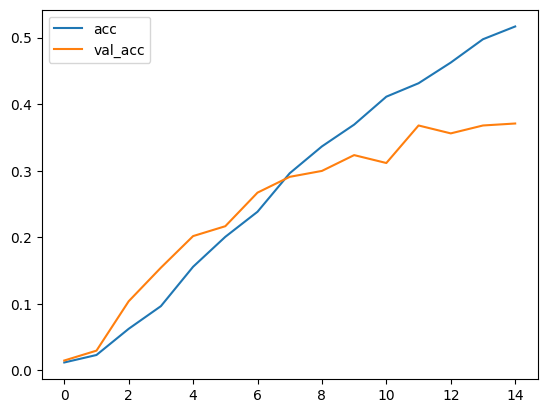

In [32]:
overfit_info.plot.line()

##Checking prodition

In [33]:
from tensorflow.keras.utils  import load_img
from keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import img_to_array

input_dim=(224,224)
image=load_img('/content/drive/MyDrive/Kaggle/test/ffd304c521f43819f3824177fd9efeb0.jpg', target_size=input_dim)
image=img_to_array(image)
image=image.reshape((1,*image.shape))
image=preprocess_input(image)

In [34]:
from keras.models import load_model
Last_model=load_model('model.h5')
res=Last_model.predict(image)

1/1 [==============================] - 1s 790ms/step


In [35]:
s=np.argsort(res)[0][-5:]
s

array([88, 69, 25, 92, 21])

In [36]:
labelE.inverse_transform(s)

array(['pug', 'leonberg', 'bull_mastiff', 'saint_bernard', 'boxer'],
      dtype=object)

## Training one more line

In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19

vgg_model=VGG19(weights='imagenet', include_top=False)

x=vgg_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
out=Dense(120,activation='Softmax')(x)

model_2=Model(inputs=vgg_model.input, outputs=out)

for layer in vgg_model.layers[:-2]:
  layer.trainable=False
for layer in vgg_model.layers[-2:]:
  layer.trainable=True

from keras.optimizers import Adam

optim=Adam()

model_2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [38]:
history_2=model_2.fit(X_train,y_train, batch_size=256, epochs=40, validation_data=(X_val, y_val), callbacks=[earlystop])
model_2.save('model_2.h5')

Epoch 1/40
12/12 [==============================] - 22s 2s/step - loss: 9.9494 - accuracy: 0.0162 - val_loss: 4.6705 - val_accuracy: 0.0148
Epoch 2/40
12/12 [==============================] - 16s 1s/step - loss: 4.4405 - accuracy: 0.0595 - val_loss: 4.4528 - val_accuracy: 0.0772
Epoch 3/40
12/12 [==============================] - 17s 1s/step - loss: 4.0626 - accuracy: 0.1160 - val_loss: 4.1777 - val_accuracy: 0.1098
Epoch 4/40
12/12 [==============================] - 17s 1s/step - loss: 3.5288 - accuracy: 0.1977 - val_loss: 3.9285 - val_accuracy: 0.1721
Epoch 5/40
12/12 [==============================] - 17s 1s/step - loss: 3.0245 - accuracy: 0.3035 - val_loss: 3.5456 - val_accuracy: 0.2047
Epoch 6/40
12/12 [==============================] - 18s 1s/step - loss: 2.4899 - accuracy: 0.3983 - val_loss: 3.4441 - val_accuracy: 0.2463
Epoch 7/40
12/12 [==============================] - 18s 1s/step - loss: 2.0819 - accuracy: 0.4787 - val_loss: 3.2595 - val_accuracy: 0.2849
Epoch 8/40
12/12 [==

In [39]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
val_acc=history_2.history.get('val_accuracy')

In [41]:
acc=history_2.history.get('accuracy')

In [42]:
overfit_info=pd.DataFrame({'acc':acc,'val_acc':val_acc})

<Axes: >

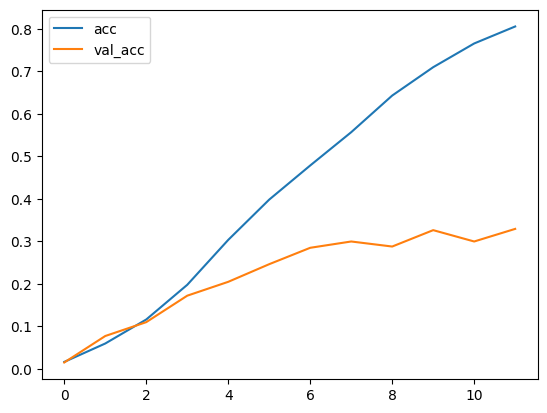

In [43]:
overfit_info.plot.line()

Checking prodition

In [44]:
input_dim=(224,224)
image=load_img('/content/drive/MyDrive/Kaggle/test/ffd304c521f43819f3824177fd9efeb0.jpg', target_size=input_dim)
image=img_to_array(image)
image=image.reshape((1,*image.shape))
image=preprocess_input(image)

In [45]:
from keras.models import load_model
Last_model=load_model('model_2.h5')
res=Last_model.predict(image)

1/1 [==============================] - 0s 153ms/step


In [46]:
s=np.argsort(res)[0][-5:]
s

array([ 92,  21, 100,  90,  25])

In [47]:
labelE.inverse_transform(s)

array(['saint_bernard', 'boxer', 'shih-tzu', 'rhodesian_ridgeback',
       'bull_mastiff'], dtype=object)

### Augumentation

In [48]:
from keras.preprocessing.image  import ImageDataGenerator

In [49]:
datagen=ImageDataGenerator( rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
                               # cross validation
                              validation_split=0.2

                             )



In [50]:
datagen.fit(X_train)

In [51]:
model_3=load_model('model_2.h5')
history_3=model_3.fit(datagen.flow(X_train,y_train, batch_size=256),validation_data=(X_val, y_val), epochs=40)
model_3.save("model_3.h5")


Epoch 1/40
12/12 [==============================] - 55s 5s/step - loss: 2.4041 - accuracy: 0.4017 - val_loss: 3.1426 - val_accuracy: 0.3561
Epoch 2/40
12/12 [==============================] - 46s 4s/step - loss: 2.2423 - accuracy: 0.4479 - val_loss: 3.2759 - val_accuracy: 0.3531
Epoch 3/40
12/12 [==============================] - 45s 4s/step - loss: 2.0718 - accuracy: 0.4780 - val_loss: 3.2080 - val_accuracy: 0.3561
Epoch 4/40
12/12 [==============================] - 44s 4s/step - loss: 1.9535 - accuracy: 0.4929 - val_loss: 3.3254 - val_accuracy: 0.3561
Epoch 5/40
12/12 [==============================] - 46s 4s/step - loss: 1.8836 - accuracy: 0.5150 - val_loss: 3.2631 - val_accuracy: 0.3798
Epoch 6/40
12/12 [==============================] - 44s 4s/step - loss: 1.7579 - accuracy: 0.5461 - val_loss: 3.3022 - val_accuracy: 0.3472
Epoch 7/40
12/12 [==============================] - 45s 4s/step - loss: 1.6401 - accuracy: 0.5514 - val_loss: 3.3003 - val_accuracy: 0.3976
Epoch 8/40
12/12 [==

In [52]:
history_3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
val_acc=history_3.history.get('val_accuracy')

In [54]:
acc=history_3.history.get('accuracy')

In [55]:
overfit_info=pd.DataFrame({'acc':acc,'val_acc':val_acc})

<Axes: >

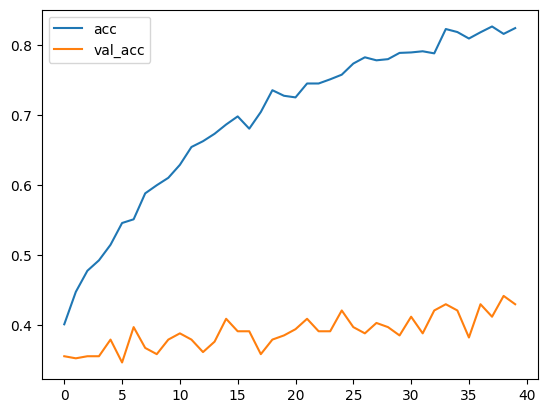

In [56]:
overfit_info.plot.line()

In [57]:

input_dim=(224,224)
image=load_img('/content/drive/MyDrive/Kaggle/test/ffd304c521f43819f3824177fd9efeb0.jpg', target_size=input_dim)
image=img_to_array(image)
image=image.reshape((1,*image.shape))
image=preprocess_input(image)

In [58]:
from keras.models import load_model
Last_model=load_model('model_3.h5')
res=Last_model.predict(image)

1/1 [==============================] - 0s 248ms/step


In [59]:
s=np.argsort(res)[0][-5:]
s

array([ 25, 100,  69,  92,  21])

In [60]:
labelE.inverse_transform(s)

array(['bull_mastiff', 'shih-tzu', 'leonberg', 'saint_bernard', 'boxer'],
      dtype=object)

In [61]:
def validate (X,y):
  for model_img in ['model.h5', 'model_2.h5', 'model_3.h5']:
    model=load_model(model_img)
    pred=model.predict(X)
    top3=np.argsort(pred)[:,-3:]
    actual=np.argmax(y, axis=1)
    res=top3-actual.reshape(-1,1)
    ana =np.product(res,axis=1)
    print(model_img, np.sum(ana==0)/ana.shape[0])


In [62]:
validate(X_train,y_train)

95/95 [==============================] - 13s 139ms/step
model.h5 0.888595041322314
95/95 [==============================] - 13s 140ms/step
model_2.h5 0.9963636363636363
95/95 [==============================] - 13s 141ms/step
model_3.h5 0.9996694214876033
